<a href="https://colab.research.google.com/github/wisrovi/RedesNeuronales/blob/master/07MAIR-WilliamSteveRodriguezVillamizar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Nota sobre notebook (leer antes de ejecutar otra linea)

# 1. Bibliografia

In [0]:
#urlArchivos = "https://drive.google.com/drive/folders/1w2w5dAF269C646RBwwU33YLNUG4JRfh9?usp=sharing"

In [0]:
#!pip install tensorflow==2.0.0-alpha0

In [0]:
#https://github.com/jbagnato/machine-learning
#https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python#cnn
#https://www.datacamp.com/community/blog/keras-cheat-sheet
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
#https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

# 2. Iniciar Sistema

## 2.1. Importar Librerias

In [4]:
#importo las librerias que se van a necesitar
import pickle
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from numpy import expand_dims

from keras import models
from keras import layers

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical #para que las salidas queden parametrizadas en binario

from sklearn.metrics import classification_report #para ver parametros 

from keras.applications.inception_v3 import decode_predictions #para ver varios items de prediccion

#para autoescalar la imagen al tamaño requerido por la red a reentrenar
from keras.applications.inception_v3 import preprocess_input

#Incrementar el número de ejemplos para evitar overfitting (junto con dropout)
#Generar datos a partir de los presentes, a través de transformaciones
from keras.preprocessing.image import ImageDataGenerator



# Para las librerias para la red neuronal
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

#callback para mejorar los entrenamientos
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  

Using TensorFlow backend.


## 2.2. Conexion con Google y Drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
###################################################################################################
BASE_FOLDER = '/content/gdrive/My Drive/Master IA/Redes Neuronales/'
###################################################################################################

In [0]:
#le indicamos al colaboratory que las importaciones de librerias propias se haran tambien desde el directorio base
import sys
sys.path.append(BASE_FOLDER)

## 2.3 Importar Librerias propias

In [0]:
from ModeloExterno import ModeloExterno

## 2.4. Funciones

In [0]:
#Algunas funciones utiles
def plot_image(img, title=""):
    #plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    #plt.axis('off')
    plt.show()

def convertLabelsToNumbers(y_train):
    # Transformando las labels de texto a valores numéricos
    y = np.unique(y_train)
    mapping = { key : value for key,value in zip(y,range(len(y)))}
    processed_y = np.array([mapping[i] for i in y_train])
    #print(len(mapping))
    return processed_y

def DividirDatos_Train_Test_Predic(x, y, porcentaje=0.33, randomDiv=52):
    # dividir los datos entre training, test y predic
    X_train, X_test, y_train, y_test = train_test_split(
        x_train_all, processed_y, 
        test_size=porcentaje, 
        random_state=randomDiv)
    print("División todo el dataset en: train y test completa")

    X_test, X_predic, y_test, y_predic = train_test_split(
        X_test, y_test, 
        test_size=porcentaje, 
        random_state=randomDiv)
    print("División dataset test en: test y predict completa")
    
    #Hacemos el One-hot Encoding
    train_Y_one_hot = to_categorical(y_train)
    test_Y_one_hot = to_categorical(y_test)
    predic_Y_one_hot = to_categorical(y_predic)
    print("Conversión de salidas en categorias completa")

    return (X_train, train_Y_one_hot), (X_test, test_Y_one_hot), (X_predic, predic_Y_one_hot)

def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['acc'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_pred(pred):
    plt.figure(figsize=(8, 2))
    classes = [c[1] for c in pred]
    probas = [c[2] for c in pred]
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, probas, align='center')
    plt.yticks(y_pos, classes)
    plt.gca().invert_yaxis()
    plt.xlabel('Probability')
    plt.xlim(0, 1)

def DefineCallback(nameFileIfSave): #guardar el mejor modelo w.r.t en val_losses
    """
    Agradecimientos a Data Talks, 
    url: https://www.youtube.com/watch?v=Gl-N3xr5zLI
    """    
    #EarlyStopping, detener el entrenamiento una vez que su pérdida comienza a aumentar 
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=5, #argumento de patience representa el número de épocas antes de detenerse una vez que su pérdida comienza a aumentar (deja de mejorar). 
        min_delta=0,  #es un umbral para cuantificar una pérdida en alguna época como mejora o no. Si la diferencia de pérdida es inferior a min_delta , se cuantifica como no mejora. Es mejor dejarlo como 0 ya que estamos interesados ​​en cuando la pérdida empeora.
        mode='auto')
        
    ModelCheckpoint(
        nameFileIfSave + 'model-{Epoch:03d}-{acc:03f}-{val_acc:03f}.h5', 
        monitor='val_loss',
        save_best_only=True, 
        mode='min')

    #ReduceLROnPlateau, que si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, 
        patience=5, 
        epsilon=1e-4, 
        mode='min')
    
    callbacks_list = [early_stop, reduce_lr, mcp_save]  
    return callbacks_list

#hago las conversiones a la imagen
dataAumentationApliqued = False
def ConverImageUsingImageDataGenerator(datagen, imagen, nombre, cantidadConversiones):
    listaConversiones = []
    listaEtiquetasCadaConversion = []
    imagen4dimensiones = expand_dims(imagenConvertir, 0)
    imagen3dimensiones = np.squeeze(imagen4dimensiones)
    listaConversiones.append(convertNumpyToList(imagen3dimensiones))

    iterator_datagen_train = datagen.flow(imagen4dimensiones, batch_size=1)

    for i in range(cantidadConversiones):
        batch = iterator_datagen_train.next()
        image = np.squeeze(batch[0])
        listaConversiones.append(convertNumpyToList(image))

    for i in range(len(listaConversiones)):
        listaEtiquetasCadaConversion.append(nombreImagen)
    

    return listaConversiones, listaEtiquetasCadaConversion

def convertNumpyToList(imagenNumpy):
    return list(imagenNumpy)

def convertListoToNumpy(imagenList):
    return array(imagenList)

## 2.5. Importar Dataseet y clases

In [10]:
#Cargo los archivos de clases y las imagenes
with open(BASE_FOLDER+"pickle_all_images_df-002.pickle", "rb") as input_file:
    x_train_all = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_train_all = pickle.load(input_file)

number_of_classes = len(y_train_all)

print("Entradas: ",x_train_all.shape)
print("Salidas: ", number_of_classes)

Entradas:  (9145, 128, 128, 3)
Salidas:  9145


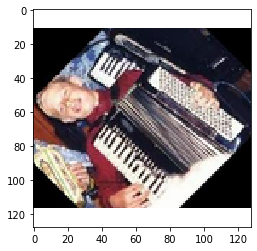

In [11]:
#show a image
plot_image(x_train_all[15])

## 2.6. Aumentar el set de datos con DataGenerator (Opcional pero mejora los modelos cuando se utiliza)

### 2.6.1 Creando el modelo generador de datos

In [0]:
#Creamos el datagen del ImageDataGenerator para definir que cambios podria tener la imagen original

datagen = ImageDataGenerator(
    rotation_range=25, # grados de rotacion aleatoria
    width_shift_range=0.15, # fraccion del total (1) para mover la imagen
    height_shift_range=0.15, # fraccion del total (1) para mover la imagen
    shear_range=0.05, # deslizamiento
    zoom_range=0.1, # rango de zoom
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    fill_mode='nearest', # como rellenar posibles nuevos pixeles
    channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
)

### 2.6.2.Aplicando el data aumentation en el dataset original

In [13]:
cantidadConversiones = 2 #se realizarán estas conversiones
#También se incluirá la imagen original (en la practica no se suele usar la imagen original, pero para tener un dataset más grande en esta oportunidad la incluiremos)


if dataAumentationApliqued == False:
    print("Cantidad imagenes iniciales: ", len(x_train_all))
    print("Cantidad etiquetas iniciales: ", len(y_train_all))
    print("Tipo datos iniciales: ", type(x_train_all))
    listadoImagenes = []
    listaEtiquetasImagen = []
    for imagenProcesar in range(len(x_train_all)):    
        imagenConvertir = x_train_all[imagenProcesar] #elijo la imagen a usar de todo el dataset
        nombreImagen = y_train_all[imagenProcesar]
        listaConversiones, listaEtiquetasCadaConversion = ConverImageUsingImageDataGenerator(datagen, imagenConvertir, nombreImagen, cantidadConversiones)
        #añado las conversiones a la lista con append
        for i in range(len(listaConversiones)):
            listadoImagenes.append(listaConversiones[i])
            listaEtiquetasImagen.append(listaEtiquetasCadaConversion[i])

    #convierto la lista nuevamente a numpy para entregarla a los modelos
    x_train_all = convertListoToNumpy(listadoImagenes)
    y_train_all = convertListoToNumpy(listaEtiquetasImagen)
    print("Cantidad imagenes finales: ", len(x_train_all))
    print("Cantidad etiquetas finales: ", len(y_train_all))
    print("Tipo datos finales: ", type(x_train_all))
    dataAumentationApliqued = True
else:
    print("No se puede aplicar dataAumentation varias veces, si desea usarlo nuevamente, vuelva a reiniciar el colab (disponible en el menú de 'Entorno de ejecución').")

Cantidad imagenes iniciales:  9145
Cantidad etiquetas iniciales:  9145
Tipo datos iniciales:  <class 'numpy.ndarray'>
Cantidad imagenes finales:  27435
Cantidad etiquetas finales:  27435
Tipo datos finales:  <class 'numpy.ndarray'>


# 3. Repartiendo los datos entre Train, test, eval y predic

In [12]:
print("Cantidad imagenes: ", len(x_train_all))
print("Cantidad etiquetas: ", len(y_train_all))

Cantidad imagenes:  9145
Cantidad etiquetas:  9145


In [13]:
processed_y = convertLabelsToNumbers(y_train_all)
salidasCategoricas = to_categorical(processed_y)

classesImageGenerator = np.unique(salidasCategoricas)
nClassesImageGenerator = len(salidasCategoricas[1])
print("Cantidad de categorias en las clases",nClassesImageGenerator)

Cantidad de categorias en las clases 102


In [14]:
imagen = 250
print(processed_y[imagen], y_train_all[imagen])

6 airplanes


In [15]:
classes = np.unique(processed_y)
nClasses = len(classes)

(X_train, y_train), (X_test, y_test), (X_predic, y_predic) = DividirDatos_Train_Test_Predic(x_train_all, processed_y)

print("Training (66.98%)") 
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print() 
print("Test (22.1%)") 
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print()
print("Predict (10.89%)") 
print("X_predic", X_predic.shape)
print("y_predic", y_predic.shape)

print()
if y_predic.shape[1] == y_test.shape[1] and y_test.shape[1] == y_train.shape[1]:
    print("Distribución correcta")
else:
    print("Fallo en la distribución")

División todo el dataset en: train y test completa
División dataset test en: test y predict completa
Conversión de salidas en categorias completa
Training (66.98%)
X_train (6127, 128, 128, 3)
y_train (6127, 102)

Test (22.1%)
X_test (2022, 128, 128, 3)
y_test (2022, 102)

Predict (10.89%)
X_predic (996, 128, 128, 3)
y_predic (996, 102)

Distribución correcta


In [0]:
#Creamos el Set de Entrenamiento y Validación
#divido los datos de entrenamiento en dos, un 80% para el entrenamiento y otro 20% para validacion
train_X,valid_X,train_label,valid_label = train_test_split(
    X_train, y_train, 
    test_size=0.1, random_state=43)

print("training")
print(train_X.shape)
print(train_label.shape)
print()
print("Valid")
print(valid_X.shape)
print(valid_label.shape)

# 4. Nueva Red Neuronal

## Red Neuronal

In [0]:
modelExtern = ModeloExterno(nombreModelo="wisrovi-nuevoModelo", rutaBase=BASE_FOLDER)

In [0]:
print("********** Modelo *********")

new_model = Sequential()
new_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )
new_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add(MaxPooling2D((2, 2),padding='same'))
new_model.add(Dropout(0.5))

new_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )

new_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(64, activation='relu'))

new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.5)) #apagar un 50% de manera aleatoria para reducir la cantidad de parametros
new_model.add(Flatten()) #para aplanar todas las capas
new_model.add(Dense(nClasses, activation='softmax')) #Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion

new_model.summary()

new_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modelExtern.GuardarModelo(new_model)

## Entrenar el modelo

In [0]:
#Entreno el modelo
numeroEntrenamientos = 30 #Al final de cada entrenamiento guardo los mejores pesos
numeroEpocas = 10  #ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = new_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas, 
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback()
        )
        
    plot_history(history)
    
    test_eval = new_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modelExtern.GuardarPesosModelo()
        oldModel = new_model
    else:
        new_model = oldModel
    print("***************")    
    print()

In [0]:
#valido el modelo
test_eval = new_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [0]:
modelExtern.GuardarPesosModelo()

## Cargar Modelo Red Neuronal Guardado

In [0]:
modeloCargado = modelExtern.CargarModeloGuardado(True)

In [0]:
#valido el modelo
test_eval = modeloCargado.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# 5. Reentrenar un modelo de ImageNet

## Cargar Modelo ImageNet

In [0]:
# VGG16, VGG19, ResNet50, 
#Xception, InceptionV3, InceptionResNetV2, 
#MobileNetV2, DenseNet, RasNet


#https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

from keras.applications import VGG16 
conv_base = VGG16(weights='imagenet',
                 include_top=False, # Si se deben incluir o no las capas de salida originales del modelo
                 input_shape=(128,128,3))

congelarTodoModeloImagenet = False
if congelarTodoModeloImagenet:
  conv_base.trainable = False
else:
  # Freeze the layers except the last 4 layers
  cantidadCapasFinalesDescongelar = 5
  for layer in conv_base.layers[:-cantidadCapasFinalesDescongelar]:
      layer.trainable = False
      pass

  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
      pass
      print(layer, layer.trainable)

conv_base.summary()

## Crear nuestro modelo e incluirle el modelo de imageNet

In [0]:
modeloTrasnferenciaConocimiento = ModeloExterno(nombreModelo="wisrovi-transferLearning", rutaBase=BASE_FOLDER)

In [0]:
pre_trained_model = models.Sequential()
pre_trained_model.add(conv_base)

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros


pre_trained_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )

pre_trained_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros

#para aplanar todas las capas
#esto se hace debido a que el modelo de VG16 nos da 4 dimensiones de salida, y con esto reducimos las dimensiones a dos: numero datos, numero clases
pre_trained_model.add(Flatten()) 

# conectarlo a nueva parte densa
# Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion
pre_trained_model.add(Dense(nClasses, activation='softmax')) 

pre_trained_model.summary()

# compilar el modelo
pre_trained_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modeloTrasnferenciaConocimiento.GuardarModelo(pre_trained_model)

## Entrenar Modelo Con conocimiento Transferido

In [0]:
#Entreno el modelo

#Al final de cada entrenamiento guardo los mejores pesos
numeroEntrenamientos = 30

#ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
numeroEpocas = 15

#ver datos entrenamiento
print("Int: ", train_X.shape)
print("Out: ", train_label.shape)

oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = pre_trained_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas,        
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback()
        )
        
    plot_history(history)   

    test_eval = pre_trained_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modeloTrasnferenciaConocimiento.GuardarPesosModelo()
        oldModel = pre_trained_model
    else:
        pre_trained_model = oldModel
    print("***************")    
    print()

In [0]:
modeloCargadoTransferenciaConocimiento = modeloTrasnferenciaConocimiento.CargarModeloGuardado(True)

In [0]:
#valido el modelo
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [0]:
url = 'https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/'

# 6. Conclusiones

Al usar la transferencia de conocimiento es más facil alcanzar un modelo de clasificacion óptimo para el objetivo propuesto en pocas epocas de reentrenamiento